# <center>Data Mining Project Code</center>

** **
## <center>*03 - Cuisine Preference Clustering*</center>

** **

In this notebook, we aim to understand customer behaviors and preferences by clustering them based on their culinary orders. By segmenting customers according to the types of cuisines they frequently order, we can uncover patterns in their consumption habits. This information will allow businesses to tailor marketing strategies, optimize inventory, and offer personalized recommendations, ultimately enhancing the customer experience.

The primary goal of this notebook is to apply unsupervised learning techniques to identify distinct customer groups based on their preference for different cuisines. We will utilize clustering algorithms such as KMeans, Hierarchical Clustering, SOM and Density-Based Algorithms to form these groups, and evaluate the clustering quality using various metrics like R², Silhouette Score, and Calinski-Harabasz Index.

At the end, we will compare our best solutions and explore the best one, creating customer profiles for each segment and interpreting their characteristics. By doing so, we aim to provide actionable insights for businesses to enhance customer satisfaction and improve operational efficiencies.


The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# Table of Contents

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>

1. [Clustering](#2.-Clustering) <br><br>


# 1. Importing Libraries & Data

In [59]:
import pandas as pd
import numpy as np
from IPython.display import display 

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Clustering algorithms
from sklearn.cluster import AgglomerativeClustering, KMeans
from kmodes.kprototypes import KPrototypes

# Evaluation
from sklearn.metrics import silhouette_score, silhouette_samples

# Segmentation
import segmentation as s

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Others
import functions as f

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

path = './plots/customer_data/'

<br>

**Customer data**

In [2]:
data = pd.read_csv('data/preprocessed_data.csv', 
                   index_col = "customer_id")

customer_data = data[s.customer_info]

In [3]:
customer_data['customer_region'] = customer_data['customer_region'].replace(0, '0000')
customer_data['customer_region'] = customer_data['customer_region'].astype(str)
customer_data['customer_region'].unique()

array(['2360', '8670', '4660', '2440', '0000', '4140', '2490', '8370',
       '8550'], dtype=object)

In [7]:
customer_data

,customer_region,customer_age,is_repeat_customer
customer_id,,,
1b8f824d5e,2360,18.0,1
5d272b9dcb,8670,17.0,1
f6d1b2ba63,4660,38.0,1
180c632ed8,4660,26.0,1
4eb37a6705,4660,20.0,1
...,...,...,...
f4e366c281,8670,30.0,0
f6b6709018,8670,26.0,0
f74ad8ce3f,8670,24.0,0


In [8]:
customer_data['is_repeat_customer'].unique()

array([1, 0])

<br>

**Product data**

In [4]:
product_data = data[s.product_vendor]
product_data

,vendor_count,product_count,is_chain
customer_id,,,
1b8f824d5e,2,5,1
5d272b9dcb,2,2,2
f6d1b2ba63,1,2,2
180c632ed8,2,3,1
4eb37a6705,2,5,0
...,...,...,...
f4e366c281,1,1,1
f6b6709018,1,1,0
f74ad8ce3f,1,1,1


<br>

# 2. Clustering

**Scale Data Before Clustering**

In [9]:
scaler = MinMaxScaler()

**Customer data**

For this data, we are going to consider only the feature `customer_age` given that its the only numerical in this dataset.

In [10]:
customer_data['customer_age'] = scaler.fit_transform(customer_data[['customer_age']])

In [15]:
def column_index(df, query_cols):
  '''
  returns the indices of the query_cols
  '''
  cols = df.columns.values
  sidx = np.argsort(cols)
  return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [18]:
cat_cols = ['customer_region', 'is_repeat_customer']
categorical_indices = column_index(customer_data, cat_cols)
categorical = list(categorical_indices)

In [20]:
cat_cols = ['customer_region', 'is_repeat_customer']
categorical_indices = column_index(customer_data, cat_cols)
categorical = list(categorical_indices)

cost = []
for cluster in range(2,16):
    try:
        model = KPrototypes(n_clusters=cluster, init="Cao", random_state=42)
        model.fit_predict(customer_data, categorical= categorical)
        cost.append(model.cost_)
        print("Cluster Initiation: {}".format(cluster))
    except:
        break

Cluster Initiation: 2
Cluster Initiation: 3
Cluster Initiation: 4
Cluster Initiation: 5
Cluster Initiation: 6
Cluster Initiation: 7
Cluster Initiation: 8
Cluster Initiation: 9
Cluster Initiation: 10
Cluster Initiation: 11
Cluster Initiation: 12
Cluster Initiation: 13
Cluster Initiation: 14
Cluster Initiation: 15


In [30]:
data_cost = pd.DataFrame({"Cluster":range(2,16),"Cost":cost})
data_cost

,Cluster,Cost
0,2,1425.164565
1,3,974.243819
2,4,844.433764
3,5,772.183266
4,6,716.423879
5,7,693.932826
6,8,654.297450
7,9,633.526766
8,10,502.162838
9,11,392.561844


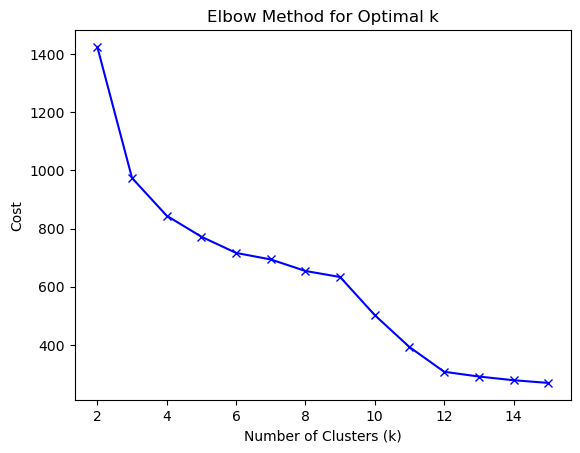

In [28]:
plt.plot(range(2,16), cost, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [32]:
possible_k = [5, 6]

In [35]:
model_5 = KPrototypes(n_clusters= 5, init= "Cao",random_state=42)
model_5.fit_predict(customer_data, categorical= categorical)

array([2, 0, 4, ..., 0, 1, 4], dtype=uint16)

Getting the Cluster Centroids.

For the numerical features it will use the average while the categorical features use the mode.

In [37]:
model_5.cluster_centroids_

array([['0.14994749562465373', '4.0', '8670', '1'],
       ['0.42959781335415825', '0.0', '8670', '1'],
       ['0.17496500233319792', '2.0', '2360', '1'],
       ['0.20016382455879225', '3.0', '2440', '1'],
       ['0.17668065470719196', '1.0', '4660', '1']], dtype='<U32')

In [44]:
customer_data["Cluster labels"]= model_5.labels_
customer_data["Segment"]= customer_data["Cluster labels"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth", 4:"Fifth"})

# Order the clusters
customer_data["Segment"] = customer_data["Segment"].astype("category")
customer_data["Segment"] = customer_data["Segment"].cat.reorder_categories(["First","Second","Third","Fourth","Fifth"])

customer_data.head()

,customer_region,customer_age,is_repeat_customer,cluster_kmeans5,Cluster labels,Segment
customer_id,,,,,,
1b8f824d5e,2360,0.046154,1,2,2,Third
5d272b9dcb,8670,0.030769,1,4,0,First
f6d1b2ba63,4660,0.353846,1,1,4,Fifth
180c632ed8,4660,0.169231,1,1,4,Fifth
4eb37a6705,4660,0.076923,1,1,4,Fifth


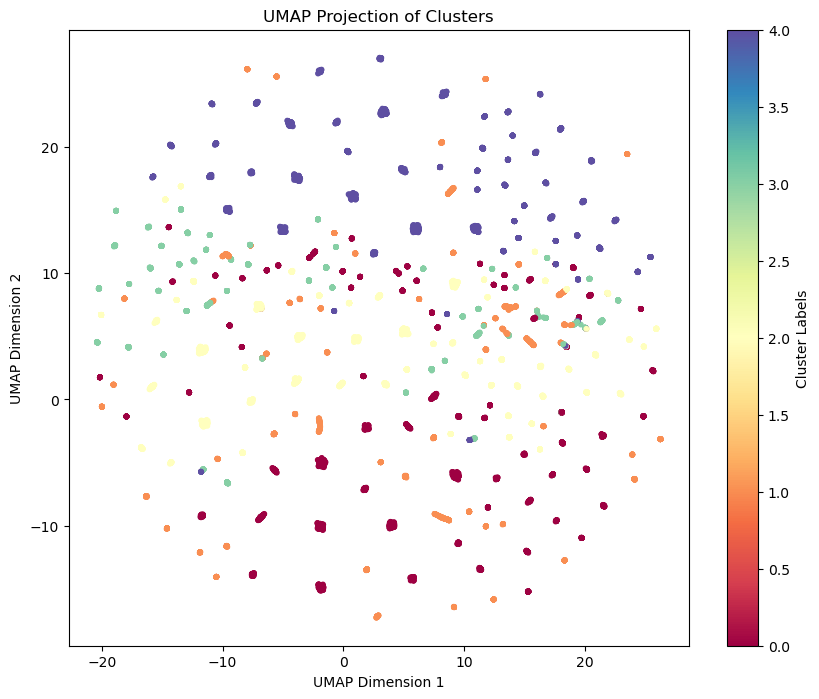

In [51]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Assuming `customer_data` has numeric and categorical features, and 'Cluster labels'
numeric_cols = ['customer_age']
categorical_cols = ['customer_region', 'is_repeat_customer']

# Extract numeric data
numeric_data = customer_data[numeric_cols].values

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(customer_data[categorical_cols])

# Combine the numeric and encoded categorical data
processed_data = np.hstack((numeric_data, encoded_cats))

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(processed_data)

# Plot the UMAP projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                      c=customer_data['Cluster labels'], 
                      cmap='Spectral', s=10)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("UMAP Projection of Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


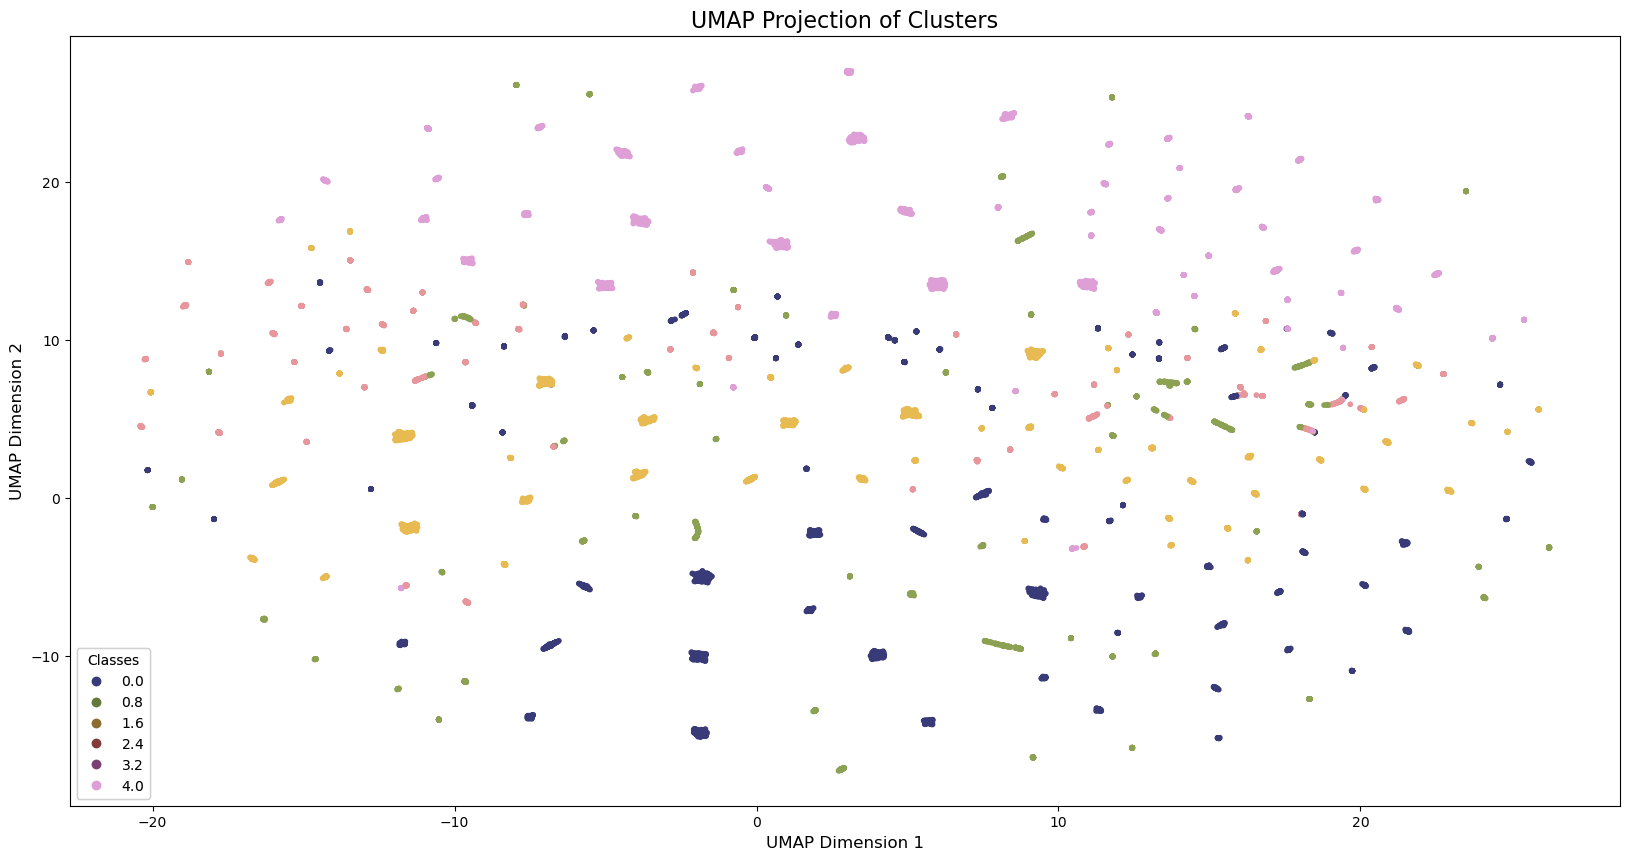

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))

# Use the UMAP embedding for scatterplot
scatter = ax.scatter(
    embedding[:, 0],  # UMAP dimension 1
    embedding[:, 1],  # UMAP dimension 2
    s=10,             # Marker size
    c=customer_data['Cluster labels'],  # Cluster labels for color coding
    cmap='tab20b',    # Colormap
    alpha=1.0         # Transparency
)

# Create a legend with unique colors for each cluster
legend1 = ax.legend(
    *scatter.legend_elements(num=len(customer_data['Cluster labels'].unique())),  # Generate legend elements dynamically
    loc="lower left",  # Legend position
    title="Classes"    # Legend title
)

ax.add_artist(legend1)  # Add legend to the plot

# Add titles and labels
ax.set_title("UMAP Projection of Clusters", fontsize=16)
ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)

plt.show()


<br>

K = 6

In [36]:
model_6 = KPrototypes(n_clusters= 6, init= "Cao",random_state=42)
model_6.fit_predict(customer_data, categorical= categorical)

array([3, 4, 1, ..., 4, 0, 1], dtype=uint16)

In [53]:
customer_data["Cluster labels_6"]= model_6.labels_
customer_data["Segment_6"]= customer_data["Cluster labels_6"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth", 4:"Fifth", 5:"Sixth"})

# Order the clusters
customer_data["Segment_6"] = customer_data["Segment_6"].astype("category")
customer_data["Segment_6"] = customer_data["Segment_6"].cat.reorder_categories(["First","Second","Third","Fourth","Fifth", "Sixth"])

customer_data.head()

,customer_region,customer_age,is_repeat_customer,cluster_kmeans5,Cluster labels,Segment,Cluster labels_6,Segment_6
customer_id,,,,,,,,
1b8f824d5e,2360,0.046154,1,2,2,Third,3,Fourth
5d272b9dcb,8670,0.030769,1,4,0,First,4,Fifth
f6d1b2ba63,4660,0.353846,1,1,4,Fifth,1,Second
180c632ed8,4660,0.169231,1,1,4,Fifth,1,Second
4eb37a6705,4660,0.076923,1,1,4,Fifth,1,Second


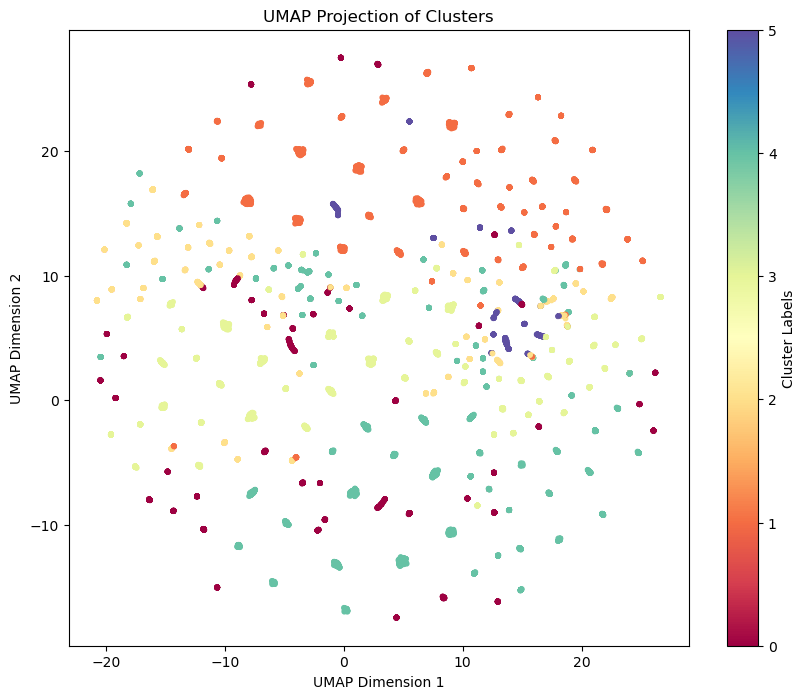

In [55]:
# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(processed_data)

# Plot the UMAP projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                      c=customer_data['Cluster labels_6'], 
                      cmap='Spectral', s=10)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("UMAP Projection of Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


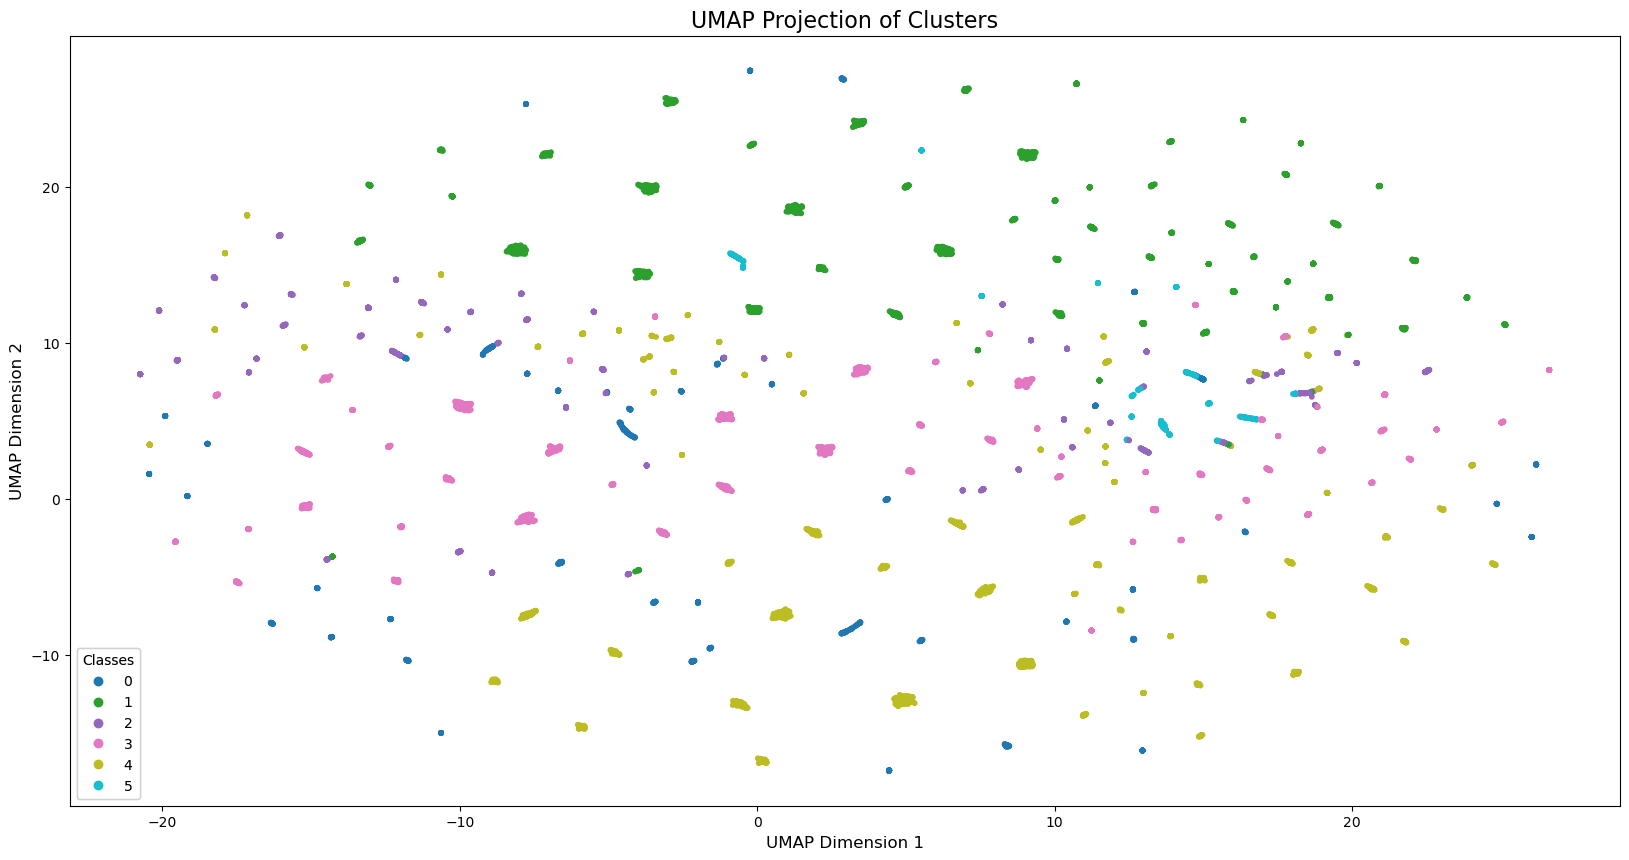

In [57]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a custom colormap with highly distinguishable colors
custom_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]
cmap = ListedColormap(custom_colors)

fig, ax = plt.subplots()
fig.set_size_inches((20, 10))

# Use the UMAP embedding for scatterplot
scatter = ax.scatter(
    embedding[:, 0],  # UMAP dimension 1
    embedding[:, 1],  # UMAP dimension 2
    s=10,             # Marker size
    c=customer_data['Cluster labels_6'],  # Cluster labels for color coding
    cmap=cmap,        # Custom colormap for distinguishable colors
    alpha=1.0         # Transparency
)

# Create a legend with unique colors for each cluster
legend1 = ax.legend(
    *scatter.legend_elements(num=len(customer_data['Cluster labels_6'].unique())),  # Generate legend elements dynamically
    loc="lower left",  # Legend position
    title="Classes"    # Legend title
)

ax.add_artist(legend1)  # Add legend to the plot

# Add titles and labels
ax.set_title("UMAP Projection of Clusters", fontsize=16)
ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)

plt.show()

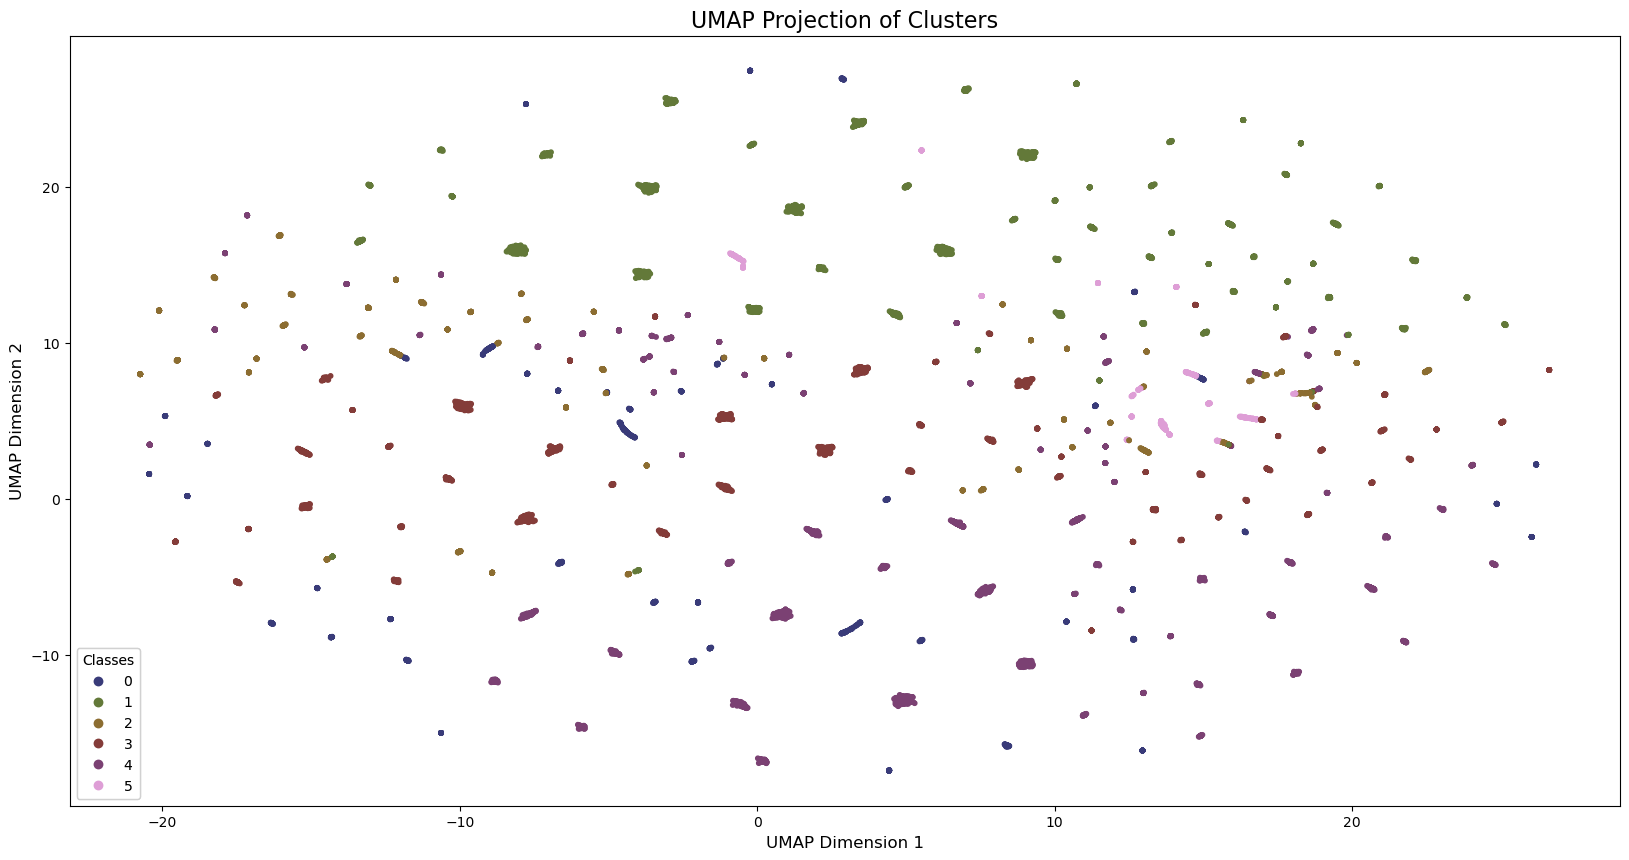

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))

# Use the UMAP embedding for scatterplot
scatter = ax.scatter(
    embedding[:, 0],  # UMAP dimension 1
    embedding[:, 1],  # UMAP dimension 2
    s=10,             # Marker size
    c=customer_data['Cluster labels_6'],  # Cluster labels for color coding
    cmap='tab20b',    # Colormap
    alpha=1.0         # Transparency
)

# Create a legend with unique colors for each cluster
legend1 = ax.legend(
    *scatter.legend_elements(num=len(customer_data['Cluster labels_6'].unique())),  # Generate legend elements dynamically
    loc="lower left",  # Legend position
    title="Classes"    # Legend title
)

ax.add_artist(legend1)  # Add legend to the plot

# Add titles and labels
ax.set_title("UMAP Projection of Clusters", fontsize=16)
ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)

plt.show()


<br>

# Gower Distance and Hierarchical clustering

In [73]:
import gower


In [62]:
customer_data_copy = customer_data.copy()

In [71]:
customer_data_copy.drop(['cluster_kmeans5', 'Cluster labels', 'Segment', 'Cluster labels_6', 'Segment_6'], axis=1, inplace=True)

In [74]:
gower_dist = gower.gower_matrix(customer_data_copy)

In [76]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering using the Gower distance matrix
linked = linkage(gower_dist, method='average')  # You can also try 'single', 'complete', etc.

# Visualize the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


: 